In [1]:
import numpy as np
import pandas as pd

from IPython.core.display import display

In [18]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
display(n_users)
display(n_items)

943

1682

In [22]:
from sklearn import cross_validation
train_data, test_data = cross_validation.train_test_split(df, test_size=0.25)
display(train_data.shape)
display(test_data.shape)

(75000, 4)

(25000, 4)

In [27]:
# Rating matrix for training
R_train = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    R_train[line[1] - 1, line[2] - 1] = line[3]
display(len(R_train[R_train > 0]))

# Rating matrix for testing
R_test = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    R_test[line[1] - 1, line[2] - 1] = line[3]
display(len(R_test[R_test > 0]))

75000

25000

In [28]:
# Index matrix for training
I_train = R_train.copy()
I_train[I_train > 0] = 1
I_train[I_train == 0] = 0
display(len(I_train[I_train > 0]))

# Index matrix for testing
I_test = R_test.copy()
I_test[I_test > 0] = 1
I_test[I_test == 0] = 0
display(len(I_test[I_test > 0]))

75000

25000

In [29]:
# Calcurate the RMSE
def rmse(I, R, Q, P):
    SSE = np.sum((I * (R - np.dot(P, Q.T)))**2)
    return np.sqrt(SSE / len(R[R > 0]))

In [33]:
# Regularization weight
_lambda = 0.1
# Dimensionlaity of latent feature space
k = 20 
# Number of users and items
m, n = R_train.shape
# Number of epochs
n_epochs = 40
# Latent user feature matrix
P = 3 * np.random.rand(m, k)
# Latent movie feature matrix
Q = 3 * np.random.rand(n, k)
# Avg. rating for each movie
# Q[0, :] = R[R != 0].mean(axis=0)
# k * k dimensional identity matrix
I = np.eye(k)

In [34]:
train_errors = []
test_errors = []

for epoch in range(n_epochs):
    # Fix Q and estimate P
    for u, Iu in enumerate(I_train):
        Au = np.dot(Q.T, Q) + _lambda * I
        Vu = np.dot(Iu, Q)
        P[u, :] = np.linalg.solve(Au, Vu)

    # Fix P and estimate Q
    for i, Ii in enumerate(I_train.T):
        Ai = np.dot(P.T, P) + _lambda * I
        Vi = np.dot(Ii, P)
        Q[i, :] = np.linalg.solve(Ai, Vi)
        
    train_rmse = rmse(I_train, R_train, Q, P)
    test_rmse = rmse(I_test, R_test, Q, P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

    print("[Epoch %d/%d] train error: %f, test error: %f" \
            %(epoch+1, n_epochs, train_rmse, test_rmse))

print("Algorithm converged")

[Epoch 1/40] train error: 3.558053, test error: 3.576437
[Epoch 2/40] train error: 3.393361, test error: 3.473728
[Epoch 3/40] train error: 3.367593, test error: 3.454299
[Epoch 4/40] train error: 3.355697, test error: 3.444978
[Epoch 5/40] train error: 3.348599, test error: 3.439127
[Epoch 6/40] train error: 3.343891, test error: 3.435097
[Epoch 7/40] train error: 3.340566, test error: 3.432196
[Epoch 8/40] train error: 3.338094, test error: 3.430025
[Epoch 9/40] train error: 3.336173, test error: 3.428338
[Epoch 10/40] train error: 3.334626, test error: 3.426983
[Epoch 11/40] train error: 3.333346, test error: 3.425861
[Epoch 12/40] train error: 3.332265, test error: 3.424911
[Epoch 13/40] train error: 3.331337, test error: 3.424089
[Epoch 14/40] train error: 3.330529, test error: 3.423368
[Epoch 15/40] train error: 3.329820, test error: 3.422728
[Epoch 16/40] train error: 3.329192, test error: 3.422157
[Epoch 17/40] train error: 3.328633, test error: 3.421646
[Epoch 18/40] train err

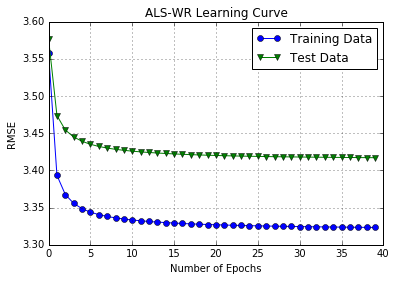

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()